# Transistor Defect Classification

In [52]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
from torchsummary import summary


## Data Loading
Here we set up the data loader objects using images stored in folders on the local disk. Note we also set the batch size and apply a series of transforms for data augmentation.

The following class is a customized torch dataset class that allows us to specify the transform process (so we can have one transform for training and another for testing).

In [53]:
# https://discuss.pytorch.org/t/why-do-we-need-subsets-at-all/49391/7
# adapted from ptrblck post
class MyLazyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [54]:
batch_size = 32

xmin_list = [0.2, 0.05, 0.2]
xmax_list = [0.45, 0.25, 0.45]

def get_data():
    data_dir_train = r"C:\Users\Filip\TransistorDefects\dataset\train"
    data_dir_test = r"C:\Users\Filip\TransistorDefects\dataset\test"
   
    transform_train = transforms.Compose([
        transforms.Resize((160,160)),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0,hue=0),
        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.5, 1)),
        transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        ])

    data_set_train_raw = datasets.ImageFolder(data_dir_train)
    data_set_test_raw = datasets.ImageFolder(data_dir_test)

    N_data_train = len(data_set_train_raw)
    N_data_test = len(data_set_test_raw)
    
    data_set_train = MyLazyDataset(data_set_train_raw,transform_train)
    data_set_test = MyLazyDataset(data_set_test_raw,transform_test)

    train_idx = list(range(N_data_train))
    np.random.shuffle(train_idx)
    
    test_idx = list(range(N_data_test))
    np.random.shuffle(test_idx)

    data_set_train_sub = torch.utils.data.Subset(data_set_train, indices=train_idx)
    data_set_test_sub = torch.utils.data.Subset(data_set_test, indices=test_idx)
    
    # data_set_train_sub, data_set_test_sub = torch.utils.data.random_split(dataset=data_set, lengths=[N_train, N_test], generator=torch.Generator().manual_seed(42))

    train = DataLoader(data_set_train_sub, batch_size=batch_size, shuffle=True)
    test = DataLoader(data_set_test_sub, batch_size=batch_size, shuffle=False)

    
    return train, test

Generate instances of the data loader...

In [55]:
train, test = get_data()

classes = ('bent_lead','cut_lead','damaged_case','good','misplaced')

Image plotting function:

torch.Size([32, 3, 160, 160])
torch.Size([32])


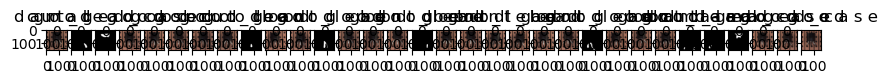

In [56]:
def train_imshow():
    dataiter = iter(train)
    images, labels = next(dataiter)
    print(images.shape)
    print(labels.shape)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=batch_size)
    for i in range(batch_size):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

train_imshow()

torch.Size([32, 3, 160, 160])
torch.Size([32])


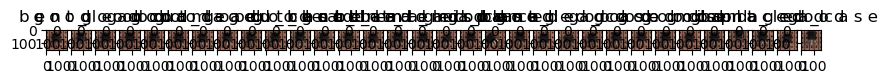

In [57]:
def test_imshow():
    dataiter = iter(test)
    images, labels = next(dataiter)
    print(images.shape)
    print(labels.shape)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=batch_size)
    for i in range(batch_size):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

test_imshow()

## Model

Let's base the model on EfficientNetB3. We'll include the option to swap out average pooling for max pooling and another option to freeze the backbone. As a default we'll assume we want to use average pooling and finetune the backbone feature layers.

In [58]:
import torchvision.models as models

In [59]:
# model = Net()
freeze_backbone = False
use_max_pooling = False

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

if use_max_pooling:
    maxpools = [k.split('.') for k, m in model.named_modules() if type(m).__name__ == 'AdaptiveAvgPool2d']
    for *parent, k in maxpools:
        setattr(model.get_submodule('.'.join(parent)),'avgpool',nn.AdaptiveMaxPool2d(output_size=1))

if freeze_backbone:
    for params in model.parameters():
        params.requires_grad = False

model.classifier = nn.Sequential(
    # nn.BatchNorm1d(num_features=1536,momentum=0.95),
    nn.Linear(in_features=1280, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    # nn.BatchNorm1d(num_features=512,momentum=0.95),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=512,out_features=5),
    nn.Softmax()
)

print(model)

#summary(model.cuda(),(5, 160, 160))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Training

Now we can train the network -- we'll use the Adam optimizer. Note we'll compute the accuracy based on the maximum output value, and track both accuracy and loss over each epoch. We'll also schedule learning rate decay but do it slowly since each epoch only covers the set of 5 images (1 for each class).

In [60]:
lr = 0.0005
lr_ratio = 0.5
patience = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=patience,factor=lr_ratio)

if torch.cuda.is_available(): # Checking if we can use GPU
    print("USING GPU")
    model = model.cuda()
    criterion = criterion.cuda()

USING GPU


In [61]:
def test_epoch():
    correct = 0
    total = 0
    k = 0
    loss_total = 0
    model.eval()
    with torch.no_grad():
        for data in test:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            loss_k = criterion(outputs, labels.cuda())
            total_k = labels.size(0)
            total += total_k
            correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
            correct += correct_k
            k += 1
            loss_total += total_k*loss_k.item()

    test_accuracy = 100*correct/total
    test_loss = loss_total/total

    return test_loss, test_accuracy

In [62]:
print(len(train))

10


Train the model...

In [63]:
train_new_model = True
model_state_dict_filename = 'model_temp.pth'

k = 0

if train_new_model:

    Lp = 50

    n_epoch = 50
    kstep = 1

    epoch_loss_train = np.zeros(n_epoch)
    epoch_acc_train = np.zeros(n_epoch)
    epoch_loss_test = np.zeros(n_epoch)
    epoch_acc_test = np.zeros(n_epoch)
    epoch_learning_rate = np.zeros(n_epoch)
    acc_test_best = 0
    count = 0

    N_train_batch = len(train)

    

    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_n = 0
        running_acc = 0.0

        model.train()

        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            if k % kstep == 0:
                optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            loss.backward()

            if k % kstep == 0:
                optimizer.step()
            
            running_n += len(outputs)

            labels_pred = np.argmax(outputs.cpu().detach().numpy(),axis=1)
            # print(outputs)
            # print(labels)
            # print(labels_pred)
            # print(loss)

            # acc = np.sum(((outputs.cpu().detach().numpy()[:,0] > 0.5) == labels.numpy()))/batch_size
            acc = np.sum(labels_pred == labels.detach().numpy())
            # print statistics
            running_loss += len(outputs)*loss.item()
            running_acc += acc
            # if i % 10 == 0:  # print every 2000 mini-batches
                # print('[%d, %5d] loss: %.10f | accuracy: %.5f' %
                    #   (epoch + 1, i + 1, running_loss / running_n, 100*acc))

            p = int(Lp*((i+1)/N_train_batch))
            s = ['#']*p + ['-']*(Lp - p)
            s = "".join(s)
            print(f'epoch: {epoch:04d} | [{s}] ({int(100*(i+1)/N_train_batch):02d}%)',end='\r')

            k += 1

        loss_test, acc_test = test_epoch()
        
        
        
        scheduler.step(acc_test)

        # if acc_test < acc_test_best:
        #     count += 1
        # else:
        #     acc_test_best = acc_test
        #     count = 0

        

        # if count >= patience:
        #     lr = lr*lr_ratio
        #     for g in optim.param_groups:
        #         g['lr'] = lr
        #     count = 0
        
        sched_lr = optimizer.param_groups[0]['lr']

        print(f'epoch: {epoch:04d} | training loss = {running_loss/running_n:0.4f} | training accuracy = {100*running_acc/running_n:0.1f} | test loss = {loss_test:0.4f} | test accuracy = {acc_test:0.1f} | count = {count} | learning rate = {sched_lr}')
        
        epoch_loss_train[epoch] = running_loss/running_n
        epoch_acc_train[epoch] = 100*running_acc/running_n
        epoch_loss_test[epoch] = loss_test
        epoch_acc_test[epoch] = acc_test
        epoch_learning_rate[epoch] = sched_lr
        
    torch.save(model.state_dict(), 'model_temp.pth')

else:
    model.load_state_dict(torch.load(model_state_dict_filename))

d:\Anaconda\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 0000 | training loss = 1.3347 | training accuracy = 68.3 | test loss = 1.2984 | test accuracy = 60.0 | count = 0 | learning rate = 0.0005
epoch: 0001 | training loss = 1.1261 | training accuracy = 75.4 | test loss = 1.2909 | test accuracy = 60.0 | count = 0 | learning rate = 0.0005
epoch: 0002 | training loss = 1.1521 | training accuracy = 73.0 | test loss = 1.2487 | test accuracy = 68.0 | count = 0 | learning rate = 0.0005
epoch: 0003 | training loss = 1.1354 | training accuracy = 76.1 | test loss = 1.2633 | test accuracy = 68.0 | count = 0 | learning rate = 0.0005
epoch: 0004 | training loss = 1.1176 | training accuracy = 79.2 | test loss = 1.2622 | test accuracy = 67.0 | count = 0 | learning rate = 0.0005
epoch: 0005 | training loss = 1.1091 | training accuracy = 78.5 | test loss = 1.2398 | test accuracy = 68.0 | count = 0 | learning rate = 0.0005
epoch: 0006 | training loss = 1.1050 | training accuracy = 77.8 | test loss = 1.2968 | test accuracy = 57.0 | count = 0 | learning

In [64]:
test_loss, test_accuracy = test_epoch()
print(test_loss)
print(test_accuracy)

0.9880212473869324
93.0


Plot training and testing loss

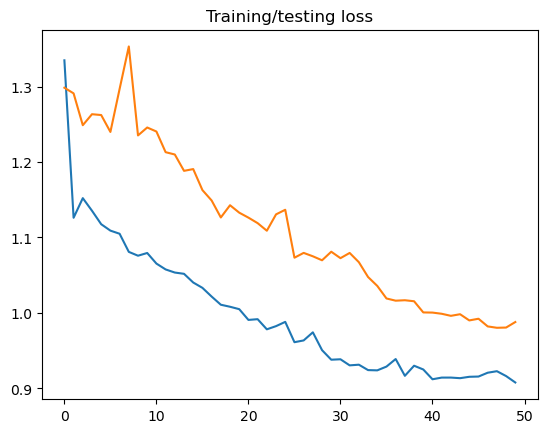

In [65]:
if train_new_model:
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,n_epoch), epoch_loss_train, np.arange(0,n_epoch), epoch_loss_test)
    ax.set_title('Training/testing loss')
    plt.show()

Plot training and testing accuracy

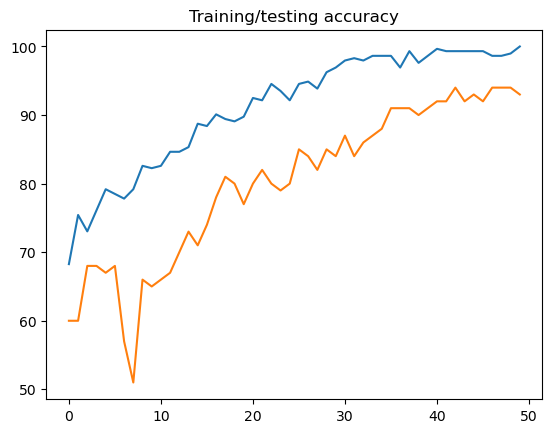

In [66]:
if train_new_model:
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,n_epoch), epoch_acc_train, np.arange(0,n_epoch), epoch_acc_test)
    ax.set_title('Training/testing accuracy')
    plt.show()

Run a final evaluation on the testing data

In [67]:
correct = 0
total = 0
k = 0
loss_total = 0
y = []
y_pred = []

print(y)
print(y_pred)

model.eval()
with torch.no_grad():
    for data in test:
        images, labels = data

        y += labels.numpy().tolist()

        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)

        y_pred += predicted.cpu().numpy().tolist()

        loss_k = criterion(outputs, labels.cuda())
        total_k = labels.size(0)
        total += total_k
        correct_k = np.sum(labels.numpy() == predicted.cpu().numpy())
        correct += correct_k
        k += 1
        loss_total += total_k*loss_k.item()

print(y)
print(y_pred)
test_accuracy = 100*correct/total
test_loss = loss_total/total

print(correct)
print(total)

[]
[]
[3, 0, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 0, 1, 0, 0, 2, 3, 4, 3, 0, 2, 3, 3, 3, 3, 3, 3, 4, 0, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 4, 3, 3, 3, 1, 3, 4, 3, 3, 3, 2, 4, 3, 3, 3, 3, 2, 2, 4, 1, 3, 3, 3, 3, 0, 2, 3, 3, 3, 4, 4, 3, 3, 1, 1, 1, 1, 2, 0, 3, 3, 3, 0, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3]
[0, 0, 2, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 3, 3, 2, 3, 4, 3, 0, 2, 3, 3, 3, 3, 3, 3, 4, 0, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 4, 3, 3, 3, 1, 3, 4, 3, 3, 3, 3, 4, 3, 2, 3, 3, 2, 2, 4, 1, 3, 3, 3, 3, 0, 2, 3, 3, 3, 4, 4, 3, 3, 1, 1, 1, 1, 2, 0, 3, 3, 3, 0, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3]
93
100


In [68]:
county = 0
countypred = 0
for i in range(len(y)):
    if y[i] == 3:
        county += 1
    if y_pred[i] == 3:
        countypred += 1

print(countypred/county)

1.0166666666666666


Let's look at the confusion matrix...

In [69]:
from sklearn.metrics import confusion_matrix

C_mat = confusion_matrix(y,y_pred)
C_mat

array([[ 8,  0,  0,  2,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  8,  2,  0],
       [ 1,  0,  2, 57,  0],
       [ 0,  0,  0,  0, 10]], dtype=int64)

In [70]:
np.sum(C_mat,axis=1)

array([10, 10, 10, 60, 10], dtype=int64)

In [71]:
C_mat_p = C_mat/(np.sum(C_mat,axis=1).reshape(-1,1))
100*C_mat_p

array([[ 80.        ,   0.        ,   0.        ,  20.        ,
          0.        ],
       [  0.        , 100.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,  80.        ,  20.        ,
          0.        ],
       [  1.66666667,   0.        ,   3.33333333,  95.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        100.        ]])

[Text(0.5, 23.52222222222222, 'Guesses'),
 Text(50.72222222222221, 0.5, 'Actual')]

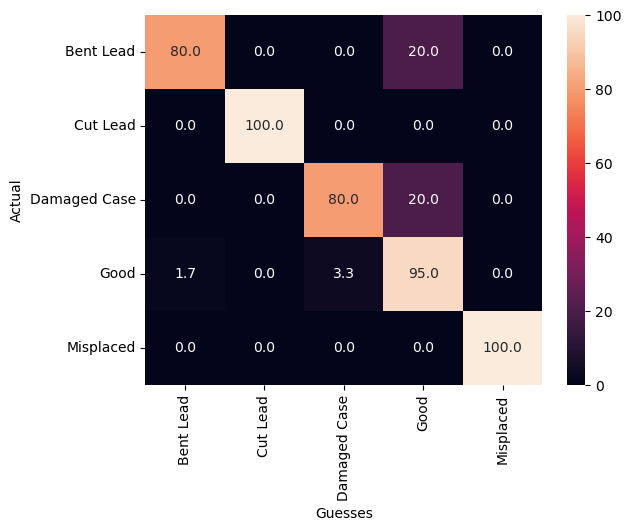

In [72]:
import seaborn as sb
labels = ['Bent Lead', 'Cut Lead', 'Damaged Case', 'Good', 'Misplaced']
s = sb.heatmap(100*C_mat_p,annot=True,fmt='.1f', xticklabels=labels, yticklabels=labels)
s.set(xlabel='Guesses', ylabel='Actual')

In [73]:
model.train()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat